## Grupo 5 - Dataset Cachorros e Gatos

Integrantes:
- Carolina
- Daniel
- Henrique 
- Léon
- Matheus


## Apresentação do Dataset 

40000 fotos de cachorros e 40000 fotos de gatos

In [1]:
import random 
from PIL import Image
import os



size = (25,25)

def load_images_from_folder(folder, label):
    data_list = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            im = Image.open(os.path.join(folder, filename))
            resized_img = im.resize(size)
            bw_img = resized_img.convert('L')
            data = list(bw_img.getdata())
            #bw_img = im.convert('L') #changed here to resize first, not sure if it's the right approach
            #resized_bw_img = bw_img.resize(size) 
            #data = list(resized_bw_img.getdata())
            features = list(data)
            data_list.append((filename, features, label))
    
    return data_list

# Specify folder paths and labels
dogs_folder = 'training_set/dogs'
cats_folder = 'training_set/cats'

# Load images and create the list
dogs_data = load_images_from_folder(dogs_folder, "dog")
cats_data = load_images_from_folder(cats_folder, "cat")
data_list = dogs_data + cats_data
print("Total images = ", len(data_list))

# Set a seed for reproducibility and shuffle the data randomly
random.seed(0)
random.shuffle(data_list)

# Define the split ratio (ideally 80% train, 20% validation but I'm going with a much smaller number here)
split_ratio = 0.99
split_index = int(len(data_list) * split_ratio)

# Split the data into training and validation sets
train_data = data_list[:split_index]
val_data = data_list[split_index:]

# Separate features and labels for training set
# remove the filename from the training data to now show up in the model
id_train, X_train, y_train = zip(*train_data) 

# Separate features and labels for validation set
id_test, X_val, y_val = zip (*val_data) 

# Change tags to 0 and 1 but it works the same way
# dog 1
# cat 0
y_train = [1 if y == "dog" else 0 for y in y_train]
y_val = [1 if y == "dog" else 0 for y in y_val]

# Add IDs to each row in train_data to make it easier to track
NaN = None

# Using the same format of the AdaTech requirements for this project
a_train_data = [(i, list(X_train[i]), y_train[i]) for i in range(len(X_train))]
test_data = [(i, list(X_val[i]), NaN) for i in range(len(X_val))]

print("Number of validation images: " , len(val_data))





Total images =  8005
Number of validation images:  81


## Algoritmo KNN 

*  Foram usados distância Euclidiana e distância Manhattan 

In [2]:
from functools import reduce

# X_train, Y_train, X_test, K
def knn_fit(train_data, train_target, test_data, k):

    # Calcula as distâncias euclidianas entre cada ponto test e todos os pontos train, retornando uma estrutura no formato
    # lista de listas.


    # euclidan distance

    square_difference = [[[(x - y)**2 for x, y in zip(p0, p1)] for p0 in list(train_data)] for p1 in list(test_data)]
    distances = [[reduce(lambda x, y: x + y, cell)**(1/2) for cell in line] for line in square_difference]

    #mahantan distance
    #square_difference = [[[abs(x - y) for x, y in zip(p0, p1)] for p0 in list(train_data)] for p1 in list(test_data)]
    #distances = [[sum(cell) for cell in line] for line in square_difference]

    # Define função para retornar os índices das observações correspondentes às menores distâncias.
    # Recebe uma lista, utiliza enumarate() para indexar os elementos da lista, .sort() para orgarnizar conforme os valores
    # da tupla gerada pelo enumarate(). Ao final, faz um slice para obter os k menores valores e retorna os índices
    # correspondentes.
    def index_k_minors(k, input_list):
        indexed_list = list(enumerate(input_list))
        indexed_list.sort(key = lambda x: x[1])
        minors = indexed_list[:k]
        index_minors = [n[0] for n in minors]
        return index_minors

    # Aplica a função index_k_minors em distances para obter os índices das observações com menores distâncias e
    # recupera os target correspondentes a essas observações.
    k_minors = [index_k_minors(k, distance) for distance in distances]
    target_minors = [[train_target[i] for i in minor] for minor in k_minors]

    # Determina o target predominante para cada uma das observações dos dados de teste.
    new_target = []
    for target_minor in target_minors:
        target_winner = target_minor[0]
        for i in range(len(target_minor)):
            if target_minor.count(target_minor[i]) > target_minor.count(target_winner):
                target_winner = target_minor[i]
        new_target.append(target_winner)

    return new_target




In [3]:
# calcula as saídas para Y (0,1) 0s são cachorros e 1s são gatos

y = knn_fit(X_train, y_train, X_val, 3)



In [4]:
# Calcula a acurácia do modelo
count = 0
for i in range(len(y)):
    if y[i] == y_val[i]:
        count += 1
print(f'Acurácia = {count/len(y)}')


Acurácia = 0.7160493827160493


## K Means

Foram utilizados 2 clusters para serem clusterizados em 0s e 1s, que seriam cachorros ou gatos

In [5]:
import random

class KMeansClustering:

    def __init__(self, k=3):
        self.k = k
        self.centroids = None

    # distance between the data points and the centroid 
    @staticmethod
    def euclidean_distance(data_point, centroid):
        return (sum((dp - c) ** 2 for dp, c in zip(data_point, centroid)))** (1/2)

    # check if the difference is less than 0.001 to break the loop
    @staticmethod
    def is_close(a, b, rel_tol=0.001):
        return abs(a - b) <= rel_tol * max(abs(a), abs(b))

    def fit(self, X, max_iteration=100):
        # Initialize centroids randomly
        self.centroids = [random.choice(X) for _ in range(self.k)]

        for j in range(max_iteration):
            print(j)
            # Assign points to the nearest centroid
            clusters = [[] for _ in range(self.k)]
            for data_point in X:
                distances = [KMeansClustering.euclidean_distance(data_point, centroid) for centroid in self.centroids]
                cluster_num = distances.index(min(distances))
                clusters[cluster_num].append(data_point)

            # Update centroids to be the mean of points in the cluster
            new_centroids = []
            for cluster in clusters:
                if len(cluster) == 0:
                    new_centroids.append(random.choice(X))  # Reinitialize if cluster is empty
                else:
                    mean = [sum(dim) / len(cluster) for dim in zip(*cluster)]
                    new_centroids.append(mean)

            # Check for convergence
            converged = True
            for old_centroid, new_centroid in zip(self.centroids, new_centroids):
                if not all(KMeansClustering.is_close(oc, nc) for oc, nc in zip(old_centroid, new_centroid)):
                    converged = False
                    break
            if converged:
                break
            else:
                self.centroids = new_centroids

        # Assign final clusters and labels
        final_clusters = [[] for _ in range(self.k)]
        labels = []
        for data_point in X:
            distances = [KMeansClustering.euclidean_distance(data_point, centroid) for centroid in self.centroids]
            cluster_num = distances.index(min(distances))
            final_clusters[cluster_num].append(data_point)
            labels.append(cluster_num)

        return final_clusters, labels





0
1
2
3
4
5
6
7
8
9
10
11


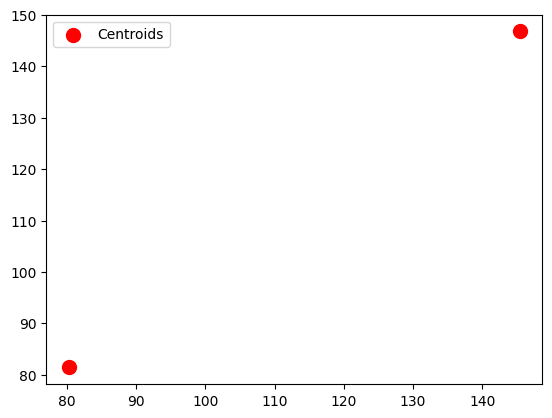

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Example usage
kmeans_cats_dogs = KMeansClustering(k=2)
clusters, labels = kmeans_cats_dogs.fit(X_train)

# Convert centroids to numpy array for easier indexing
centroids = np.array(kmeans_cats_dogs.centroids)

#Plotting the centroids of the clusters
plt.scatter(centroids[:, 0], centroids[:,1], s = 100, c = 'red', label = 'Centroids')

plt.legend()


In [7]:
count_knn = 0

for i,j in zip(labels,y_train):
    if int(i) == int(j):
        count_knn = count_knn + 1

accuracy_knn = (count_knn * 100) / len(y_train)
print(accuracy_knn)

47.34982332155477


# Plotar os resultados para o dataset Iris

Só por questões de visualização 

In [8]:
import ctypes
from sklearn import datasets


iris = datasets.load_iris()
X_iris = iris.data
kmeans_iris = KMeansClustering(k=3)
clusters, labels = kmeans_iris.fit(np.array(X_iris).tolist())

# Convert centroids to numpy array for easier indexing
centroids = np.array(kmeans_iris.centroids)




0
1
2
3
4


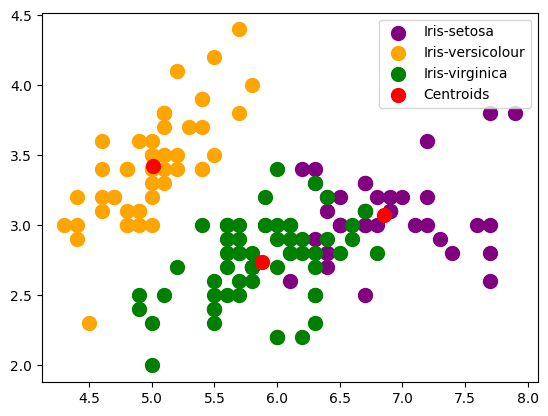

In [9]:
labels = np.array(labels)

#Visualising the clusters
plt.scatter(X_iris[labels == 0, 0], X_iris[labels == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(X_iris[labels == 1, 0], X_iris[labels == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(X_iris[labels == 2, 0], X_iris[labels == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

#Plotting the centroids of the clusters
plt.scatter(centroids[:, 0], centroids[:,1], s = 100, c = 'red', label = 'Centroids')

plt.legend()

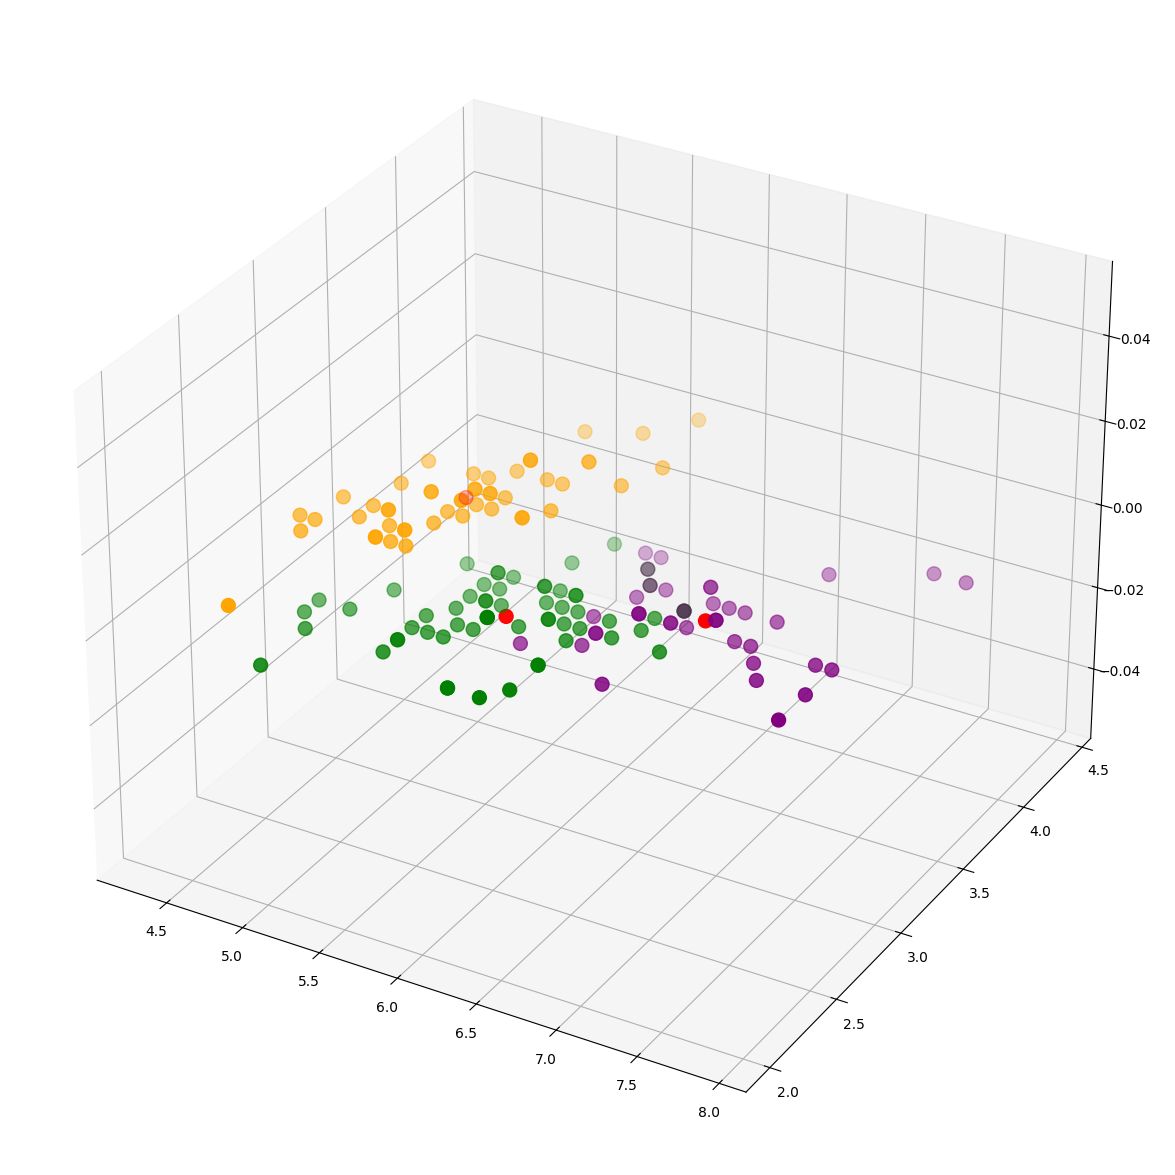

In [10]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(X_iris[labels == 0, 0], X_iris[labels == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(X_iris[labels == 1, 0], X_iris[labels == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(X_iris[labels == 2, 0], X_iris[labels == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

#Plotting the centroids of the clusters
plt.scatter(centroids[:, 0], centroids[:,1], s = 100, c = 'red', label = 'Centroids')
plt.show()

## Resultados encontrados e também análizes realizadas:

# **KNN**:

 Distancia Euclidiana: 

 - Tempo de executação: 3 min
 - teste para k entre 2 e 6
 
 * k=2 - ACC= 0.592
 * k=3 - ACC= 0.716
 * k=4 - ACC= 0.666
 * k=5 - ACC= 0.666
 * k=6 - ACC= 0.691

Distancia Manhattan:

 - Tempo de executação: 1 min
 - teste para k entre 2 e 6

 * k=2 - ACC= 0.604
 * k=3 - ACC= 0.629
 * k=4 - ACC= 0.629
 * k=5 - ACC= 0.629
 * k=6 - ACC=  0.654


 - Aumentar o tamanho de pixels não resulta em uma grande melhorar da acurácia do algoritmo

- implementaçao é mais fácil e rápida

# **K Means**

- Usamos 2 clusters para classificar os pixels entre cachorros e gatos;
- ACC: 52.77% usando o dataset inteiro (testamos com os labels do cluster feito pelo algoritmo);
- Implementacao mais complexa, precisa realizar mais passos, pode demorar para convergir (é bom colocar um critério de parada);
- Acurácia é menor se levar em conta os labels dado pelo algoritmo;
- Permite maior implementçao porque muitas vezes os labels não são disponibilizados;



**Vale lembre que um algoritmo o foco é classificação e o outro clusterização**


## E agora, é cachorro ou gato?





In [13]:
# Solicita ao usuário que insira um número de imagem de 1 a 8000
n_X_teste_individual = int(input("Digite o numero da imagem (1-8000): "))

# Determina o caminho da imagem e o tipo de animal (gato ou cachorro)
if n_X_teste_individual <= 4000:
    guess_my_pet = "cat." + str(n_X_teste_individual) + ".jpg"
    path_img = 'training_set/cats/'
else:
    guess_my_pet = "dog." + str(n_X_teste_individual - 4000) + ".jpg"
    path_img = 'training_set/dogs/'

# Abre a imagem usando o módulo PIL
image = Image.open(os.path.join(path_img, guess_my_pet))

# Exibe a imagem na tela
image.show()

# Inicializa a lista X_teste_individual
X_teste_individual = []

# Busca pelos dados da imagem em data_list
for item in data_list:
    if item[0] == guess_my_pet:
        # Adiciona as características da imagem à lista X_teste_individual
        X_teste_individual.append(item[1])
        break  # Interrompe o loop assim que a imagem é encontrada

# Executa o algoritmo KNN para classificar a imagem
k = 7
y = knn_fit(X_train, y_train, X_teste_individual, k)

# Imprime a classificação feita pelo modelo KNN
print(f"O modelo acredita que é um {'gato' if y[0] == 0 else 'cachorro'}")

O modelo acredita que é um gato
